In [3]:
!pip install transformers

In [2]:
import os 
from google.colab import drive
import csv
import pandas as pd
import tensorflow as tf
import torch
import numpy as np
import time
import datetime
import random
from transformers import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from sklearn.dummy import DummyClassifier
# from torchtext.data import Iterator

In [4]:
# TO USE COLAB GPU FOR BERT TRAINING
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [5]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [6]:
drive.mount('/content/gdrive', force_remount=True)
working_directory = '/gdrive/My Drive/ML Research ListerVosoughi/SMIP/Data'
os.chdir(os.getcwd() + working_directory)
dirpath = os.getcwd()

Mounted at /content/gdrive


In [ ]:
print(dirpath)

/content/gdrive/My Drive/ML Research ListerVosoughi/SMIP/Data


## **Training** 

In [ ]:
filename = 'masklabels.tsv'
df = pd.read_csv(dirpath + '/' + filename, sep='\t')

In [8]:
filename = 'masklabel1.tsv'
df = pd.read_csv(dirpath + '/' + filename, sep='\t')

In [10]:
len(df[df['mask_label'] == 0])
len(df[df['mask_label'] == 1])

13900

In [ ]:
temp = df[df['mask_label'] == 1]['text']
temp

6        How to Significantly Slow Coronavirus? (featur...
7        RT @TamaraBraun: When sharing supplies please ...
8        How to Significantly Slow Coronavirus? (featur...
9        RT @TamaraBraun: When sharing supplies please ...
10       RT @TaiwanBirding: #WearAMask, even crap ones ...
                               ...                        
14863    I think now almost everyone forgotten the fact...
14864    I think now almost everyone forgotten the fact...
14865    RT @buddy_21011: What’s your name? #englishbul...
14866    RT @buddy_21011: What’s your name? #englishbul...
14867    RT @buddy_21011: What’s your name? #englishbul...
Name: text, Length: 13900, dtype: object

In [21]:
tweets = df.text.values
labels = df.mask_label.values
df.head()

,Unnamed: 0,hashtags,user id,text,linked urls,retweeted user id,retweet_text,time,week,mask_label
0,0,"[{'text': 'Straya', 'indices': [75, 82]}, {'te...",1209981600173215700,"RT @CarlsCarla: Never fear, Aussies are wardin...",[],24622413.0,"Never fear, Aussies are warding off Coronaviru...",2020-04-03 08:52:30,10.0,0
1,1,"[{'text': 'Straya', 'indices': [75, 82]}, {'te...",965767890,"RT @CarlsCarla: Never fear, Aussies are wardin...",[],24622413.0,"Never fear, Aussies are warding off Coronaviru...",2020-03-03 11:04:32,10.0,0
2,2,"[{'text': 'Straya', 'indices': [75, 82]}, {'te...",812474688,"RT @CarlsCarla: Never fear, Aussies are wardin...",[],24622413.0,"Never fear, Aussies are warding off Coronaviru...",2020-03-03 11:23:41,10.0,0
3,3,"[{'text': 'Straya', 'indices': [75, 82]}, {'te...",337688338,"RT @CarlsCarla: Never fear, Aussies are wardin...",[],24622413.0,"Never fear, Aussies are warding off Coronaviru...",2020-03-03 11:14:35,10.0,0
4,4,"[{'text': 'Straya', 'indices': [75, 82]}, {'te...",1069102867686944800,"RT @CarlsCarla: Never fear, Aussies are wardin...",[],24622413.0,"Never fear, Aussies are warding off Coronaviru...",2020-03-03 14:55:13,10.0,0


In [ ]:
train, val, train_y, validation_y = train_test_split(tweets, labels, 
                                                            random_state=2018,stratify=labels, test_size=0.1)
dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(train, train_y)


DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [ ]:
dummy_clf.predict(val)
dummy_clf.score(val, validation_y)

0.8702084734364492

In [ ]:
train, val, train_y, validation_y = train_test_split(tweets, labels, 
                                                            random_state=2018,stratify=labels, test_size=0.1)

In [ ]:
train.view()

array(['Who needs a Master Chief Mask?\n#WearAMask #HaloUnited  https://t.co/HgWdDxyBhy',
       'Wear a mask, limit your movement to essentials, be a super hero 😷 😷 #WearAMaskSaveALife',
       'RT @OptimistsPrime: If Death Valley park rangers can #WearAMask in 129 degrees you can wear one in the damn grocery store. #COVID19 https:/…',
       ...,
       '@NYGovCuomo I don’t get it you, nor your fellow elected Democrats don’t believe in this.  #WearAMask #coronavirus    \n\nWhy should anyone believe or follow you? https://t.co/f039lwvx4e',
       'RT @silv24: 6.40am - Mask number 1 - waiting for the tube on my way in to work #wearamask #COVID19 https://t.co/CvYPwkxari',
       'RT @shachar_baron: Israeli reporter @BarakRavid rocking the White House today w his Theodore Herzl mask #WearAMask'],
      dtype=object)

In [ ]:
val.view()

array(['Either someone just wants their nappy changed...of they’ve just heard people STILL aren’t following Covid Gov Restrictions!! 😤\n\n...I feel ya buddy. \n\n#wearadamnmask #stayathome #mondaymood \n\n@VicGovtNews @VicGovDHHS https://t.co/lEP3cMlk63',
       'RT @thewatcher303: Always wear a mask in public!  #WearADamnMask #HomeDepot https://t.co/g1l35fHbYF',
       '@molmccann All everyone had to do was #WearAMask and social distance, but no, they knew better, so here we are now.  Thanks all you selfish people!😡',
       ...,
       'This is not even a worst case scenario estimate. \n\n#WearAMask https://t.co/tsbT8OEFEc',
       'A new design from WallsOfFame. Follow for more. #digitalart #artistoninstagram #fanart #wallsoffame #digitalart #love #mask #COVID19 #health #wearamask \nGet my art printed on awesome products. Support me at Redbubble #RBandME:  https://t.co/EEckqwbBy0 #findyourthing #redbubble',
       'RT @SidneyPowell1: OK, so #HerdImmunity is working.\nDeaths are goin

In [19]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
# Print the original tweet.
print(' Original: ', tweets[0])

# Print the tweet split into tokens.
print('Tokenized: ', tokenizer.tokenize(tweets[0]))

# Print the tweet mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(tweets[0])))

 Original:  RT @CarlsCarla: Never fear, Aussies are warding off Coronavirus with 3ply. #Straya #Stockpiling #Panicbuying #ToiletPaper #NoMasksNowuccas…
Tokenized:  ['rt', '@', 'carl', '##sca', '##rl', '##a', ':', 'never', 'fear', ',', 'aus', '##sies', 'are', 'ward', '##ing', 'off', 'corona', '##virus', 'with', '3', '##ply', '.', '#', 'stray', '##a', '#', 'stock', '##pi', '##ling', '#', 'panic', '##bu', '##ying', '#', 'toilet', '##paper', '#', 'no', '##mas', '##ks', '##now', '##uc', '##cas', '…']
Token IDs:  [19387, 1030, 5529, 15782, 12190, 2050, 1024, 2196, 3571, 1010, 17151, 14625, 2024, 4829, 2075, 2125, 21887, 23350, 2007, 1017, 22086, 1012, 1001, 15926, 2050, 1001, 4518, 8197, 2989, 1001, 6634, 8569, 14147, 1001, 11848, 23298, 1001, 2053, 9335, 5705, 19779, 14194, 15671, 1529]


In [ ]:
# Tokenize all of the tweet and map the tokens to thier word IDs.
input_ids = []

# For every tweet...
for tweet in tweets:
    # `encode` will:
    #   (1) Tokenize the tweet.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_tweet = tokenizer.encode(
                        tweet,                      # Tweet to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all tweets.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded tweet to the list.
    input_ids.append(encoded_tweet)

# Print tweet 0, now as a list of IDs.
print('Original: ', tweets[0])
print('Token IDs:', input_ids[0])

Original:  RT @CarlsCarla: Never fear, Aussies are warding off Coronavirus with 3ply. #Straya #Stockpiling #Panicbuying #ToiletPaper #NoMasksNowuccas…
Token IDs: [101, 19387, 1030, 5529, 15782, 12190, 2050, 1024, 2196, 3571, 1010, 17151, 14625, 2024, 4829, 2075, 2125, 21887, 23350, 2007, 1017, 22086, 1012, 1001, 15926, 2050, 1001, 4518, 8197, 2989, 1001, 6634, 8569, 14147, 1001, 11848, 23298, 1001, 2053, 9335, 5705, 19779, 14194, 15671, 1529, 102]


In [ ]:
print('Max tweet length: ', max([len(tweet) for tweet in input_ids]))

Max tweet length:  104


In [ ]:
# Set the maximum sequence length.
# I've chosen 400 somewhat arbitrarily. It's slightly larger than the
# maximum training tweet length of 357...
MAX_LEN = 400

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 400 values...

Padding token: "[PAD]", ID: 0

Done.


In [ ]:
# Create attention masks
attention_masks = []

# For each tweet...
for tweet in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in tweet]
    
    # Store the attention mask for this tweet.
    attention_masks.append(att_mask)

In [ ]:
# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                             stratify=labels, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             stratify=labels, test_size=0.1)

In [ ]:
tl = validation_labels.tolist()
num0 = 0
for i in tl: 
  if i == 1: num0+= 1 
num0



1390

In [ ]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 16

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [12]:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [13]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [14]:
# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

NameError: ignored

In [15]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [16]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [23]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression


skf = StratifiedKFold(n_splits=10, random_state=2018, shuffle=True)

tokenized = df.text.apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
attention_mask = np.where(padded != 0, 1, 0)
results = []
for train_index, test_index in skf.split(df.text, labels):
  X_train, X_val = padded[train_index], padded[test_index]
  train_mask, val_mask = attention_mask[train_index], attention_mask[test_index] 
  y_train, y_val = labels[train_index], labels[test_index]


  # input_ids = torch.tensor(padded)  
  # attention_mask = torch.tensor(attention_mask)


  train_inputs = torch.tensor(X_train)
  validation_inputs = torch.tensor(X_val)

  train_labels = torch.tensor(y_train)
  validation_labels = torch.tensor(y_val)

  train_masks = torch.tensor(train_mask)
  validation_masks = torch.tensor(val_mask)


  batch_size = 16

  # Create the DataLoader for our training set.
  train_data = TensorDataset(train_inputs, train_masks, train_labels)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

  # Create the DataLoader for our validation set.
  validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
  validation_sampler = SequentialSampler(validation_data)
  validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)
  # Set the seed value all over the place to make this reproducible.
  seed_val = 42

  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

  # Store the average loss after each epoch so we can plot them.
  loss_values = []


  # Number of training epochs (authors recommend between 2 and 4)
  epochs = 4

  # Total number of training steps is number of batches * number of epochs.
  total_steps = len(train_dataloader) * epochs

  # Create the learning rate scheduler.
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 0, # Default value in run_glue.py
                                              num_training_steps = total_steps)


  # For each epoch...
  for epoch_i in range(0, epochs):
      
      # ========================================
      #               Training
      # ========================================
      
      # Perform one full pass over the training set.

      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Training...')

      # Measure how long the training epoch takes.
      t0 = time.time()

      # Reset the total loss for this epoch.
      total_loss = 0

      # Put the model into training mode. Don't be mislead--the call to 
      # `train` just changes the *mode*, it doesn't *perform* the training.
      # `dropout` and `batchnorm` layers behave differently during training
      # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
      model.train()

      # For each batch of training data...
      for step, batch in enumerate(train_dataloader):

          # Progress update every 40 batches.
          if step % 40 == 0 and not step == 0:
              # Calculate elapsed time in minutes.
              elapsed = format_time(time.time() - t0)
              
              # Report progress.
              print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

          # Unpack this training batch from our dataloader. 
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using the 
          # `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids 
          #   [1]: attention masks
          #   [2]: labels 
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)
          # b_labels.type(torch.LongTensor)
          # print(b_labels.type())
          b_labels = b_labels.type(torch.cuda.LongTensor)
          # b_labels = Variable(b_labels_temp, requires_grad=True).cuda()

          # Always clear any previously calculated gradients before performing a
          # backward pass. PyTorch doesn't do this automatically because 
          # accumulating the gradients is "convenient while training RNNs". 
          # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
          model.zero_grad()        

          # Perform a forward pass (evaluate the model on this training batch).
          # This will return the loss (rather than the model output) because we
          # have provided the `labels`.
          # The documentation for this `model` function is here: 
          # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
          outputs = model(b_input_ids, 
                      token_type_ids=None, 
                      attention_mask=b_input_mask, 
                      labels=b_labels)
          
          # The call to `model` always returns a tuple, so we need to pull the 
          # loss value out of the tuple.
          loss = outputs[0]


          # features = outputs[0][:,0,:].numpy()

          # train_features, test_features, train_labels, test_labels = train_test_split(features, b_labels)

          # lr_clf = LogisticRegression()
          # lr_clf.fit(train_features, train_labels)

          # Accumulate the training loss over all of the batches so that we can
          # calculate the average loss at the end. `loss` is a Tensor containing a
          # single value; the `.item()` function just returns the Python value 
          # from the tensor.
          total_loss += loss.item()

          # Perform a backward pass to calculate the gradients.
          loss.backward()

          # Clip the norm of the gradients to 1.0.
          # This is to help prevent the "exploding gradients" problem.
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          # Update parameters and take a step using the computed gradient.
          # The optimizer dictates the "update rule"--how the parameters are
          # modified based on their gradients, the learning rate, etc.
          optimizer.step()

          # Update the learning rate.
          scheduler.step()

      # Calculate the average loss over the training data.
      avg_train_loss = total_loss / len(train_dataloader)            
      
      # Store the loss value for plotting the learning curve.
      loss_values.append(avg_train_loss)

      print("")
      print("  Average training loss: {0:.2f}".format(avg_train_loss))
      print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
          
      # ========================================
      #               Validation
      # ========================================
      # After the completion of each training epoch, measure our performance on
      # our validation set.

      print("")
      print("Running Validation...")

      t0 = time.time()

      # Put the model in evaluation mode--the dropout layers behave differently
      # during evaluation.
      model.eval()

      # Tracking variables 
      eval_loss, eval_accuracy = 0, 0
      nb_eval_steps, nb_eval_examples = 0, 0

      # Evaluate data for one epoch
      for batch in validation_dataloader:
          
          # Add batch to GPU
          batch = tuple(t.to(device) for t in batch)
          
          # Unpack the inputs from our dataloader
          b_input_ids, b_input_mask, b_labels = batch
          
          # Telling the model not to compute or store gradients, saving memory and
          # speeding up validation
          with torch.no_grad():        

              # Forward pass, calculate logit predictions.
              # This will return the logits rather than the loss because we have
              # not provided labels.
              # token_type_ids is the same as the "segment ids", which 
              # differentiates sentence 1 and 2 in 2-sentence tasks.
              # The documentation for this `model` function is here: 
              # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
              outputs = model(b_input_ids, 
                              token_type_ids=None, 
                              attention_mask=b_input_mask)
          
          # Get the "logits" output by the model. The "logits" are the output
          # values prior to applying an activation function like the softmax.
          logits = outputs[0]

          # # linear reg way 
          # new_last_hidden_states = outputs[0].detach().numpy()[0][0]
          # lr_clf.predict_proba(new_last_hidden_states)

          # Move logits and labels to CPU
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()
          
          # Calculate the accuracy for this batch of test sentences.
          tmp_eval_accuracy = flat_accuracy(logits, label_ids)
          
          # Accumulate the total accuracy.
          eval_accuracy += tmp_eval_accuracy

          # Track the number of batches
          nb_eval_steps += 1

      # Report the final accuracy for this validation run.
      print("  Accuracy: " + str(eval_accuracy/nb_eval_steps))
      print("  Validation took: {:}".format(format_time(time.time() - t0)))

  print("")
  print("Training complete!")
  results.extend(loss_values)
print(sum(results)/len(results))



======== Epoch 1 / 4 ========
Training...
  Batch    40  of    837.    Elapsed: 0:00:22.
  Batch    80  of    837.    Elapsed: 0:00:43.
  Batch   120  of    837.    Elapsed: 0:01:05.
  Batch   160  of    837.    Elapsed: 0:01:26.
  Batch   200  of    837.    Elapsed: 0:01:47.
  Batch   240  of    837.    Elapsed: 0:02:09.
  Batch   280  of    837.    Elapsed: 0:02:30.
  Batch   320  of    837.    Elapsed: 0:02:52.
  Batch   360  of    837.    Elapsed: 0:03:13.
  Batch   400  of    837.    Elapsed: 0:03:35.
  Batch   440  of    837.    Elapsed: 0:03:56.
  Batch   480  of    837.    Elapsed: 0:04:18.
  Batch   520  of    837.    Elapsed: 0:04:39.
  Batch   560  of    837.    Elapsed: 0:05:01.
  Batch   600  of    837.    Elapsed: 0:05:22.
  Batch   640  of    837.    Elapsed: 0:05:44.
  Batch   680  of    837.    Elapsed: 0:06:05.
  Batch   720  of    837.    Elapsed: 0:06:27.
  Batch   760  of    837.    Elapsed: 0:06:48.
  Batch   800  of    837.    Elapsed: 0:07:10.

  Average traini

In [ ]:
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # b_labels.type(torch.LongTensor)
        # print(b_labels.type())
        b_labels = b_labels.type(torch.cuda.LongTensor)
        # b_labels = Variable(b_labels_temp, requires_grad=True).cuda()

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    837.    Elapsed: 0:00:15.
  Batch    80  of    837.    Elapsed: 0:00:30.
  Batch   120  of    837.    Elapsed: 0:00:44.
  Batch   160  of    837.    Elapsed: 0:00:59.
  Batch   200  of    837.    Elapsed: 0:01:14.
  Batch   240  of    837.    Elapsed: 0:01:29.
  Batch   280  of    837.    Elapsed: 0:01:44.
  Batch   320  of    837.    Elapsed: 0:01:58.
  Batch   360  of    837.    Elapsed: 0:02:13.
  Batch   400  of    837.    Elapsed: 0:02:28.
  Batch   440  of    837.    Elapsed: 0:02:43.
  Batch   480  of    837.    Elapsed: 0:02:58.
  Batch   520  of    837.    Elapsed: 0:03:12.
  Batch   560  of    837.    Elapsed: 0:03:27.
  Batch   600  of    837.    Elapsed: 0:03:42.
  Batch   640  of    837.    Elapsed: 0:03:57.
  Batch   680  of    837.    Elapsed: 0:04:12.
  Batch   720  of    837.    Elapsed: 0:04:26.
  Batch   760  of    837.    Elapsed: 0:04:41.
  Batch   800  of    837.    Elapsed: 0:04:56.

  Average traini

In [ ]:
avg acuracy = 70.775

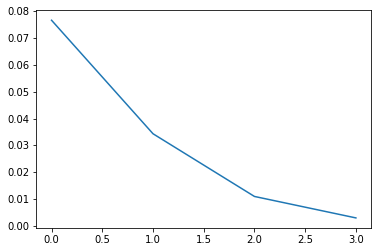

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_values)
plt.show()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model_path = os.getcwd() + '/Model/'
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('/content/gdrive/My Drive/ML Research ListerVosoughi/SMIP/Data/Model/tokenizer_config.json',
 '/content/gdrive/My Drive/ML Research ListerVosoughi/SMIP/Data/Model/special_tokens_map.json',
 '/content/gdrive/My Drive/ML Research ListerVosoughi/SMIP/Data/Model/vocab.txt',
 '/content/gdrive/My Drive/ML Research ListerVosoughi/SMIP/Data/Model/added_tokens.json')

## **Predicting**

In [ ]:
model = BertForSequenceClassification.from_pretrained(os.getcwd() + '/Model/', 
    num_labels = 2, # The number of output labels--2 for binary classification.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
    ) # Assumes already in Data folder 
tokenizer = BertTokenizer.from_pretrained(os.getcwd() + '/Model/', do_lower_case=True)

In [ ]:
df = pd.read_csv(os.getcwd() + '/all_tweets.tsv', low_memory=False, sep='\t')

In [ ]:
tweets = df.text.values

In [ ]:
print(len(tweets))

In [ ]:
# Tokenize all of the tweet and map the tokens to thier word IDs.
test_ids = []

# For every tweet...
for tweet in tweets:
    # `encode` will:
    #   (1) Tokenize the tweet.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    if tweet is np.nan: 
      # test_ids.append('')
      tweet = ''
    encoded_tweet = tokenizer.encode(
                        tweet,                      # Tweet to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        # max_length = 128,          # Truncate all tweets.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
      # print(encoded_tweet)
      # Add the encoded tweet to the list.
    test_ids.append(encoded_tweet)
# f = np.savetxt(os.getcwd() + '/encoded_tweets.txt', np.array(test_ids, dtype=object), fmt='%.18s', delimiter=', ')

Token indices sequence length is longer than the specified maximum sequence length for this model (668 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
with open(os.getcwd() + '/encoded_tweets.txt', mode='w') as out_file:
  for id in test_ids: 
    out_file.write(str(id) + '\n') 
out_file.close()

In [ ]:
f = np.savetxt(os.getcwd() + '/encoded_tweets.txt', np.array(test_ids, dtype=object), fmt='%.18s', delimiter=', ')

In [ ]:
# test_ids = np.loadtxt(os.getcwd() + '/encoded_tweets.txt', delimiter=', ', ndmin=1, dtype=object)
with open(os.getcwd() + '/encoded_tweets.txt', mode='r') as in_file:
  test_ids = []
  batch_size = 2000000
  j = 1 # number of times ive run it, needs to be 6 in end
  for i, line in enumerate(in_file):
    if i >= j*batch_size and i < (j+1)*batch_size: 
      l = line.replace('[', '').replace(']','').split(', ')
      k = [int(s.strip()) for s in l]
      test_ids.append(k)
    elif i >= (j+1)*batch_size: break
in_file.close()


In [ ]:
print(len(test_ids)/10)

1330418.9


In [ ]:
size = int(len(test_ids)/16)

In [ ]:
# Set the maximum sequence length.
# I've chosen 400 somewhat arbitrarily. It's slightly larger than the
# maximum training tweet length of 357...
MAX_LEN = 400

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
# test_ids = pad_sequences(test_ids, maxlen=MAX_LEN, dtype="long", 
#                           value=0, truncating="post", padding="post")
with open(os.getcwd() + '/padded_tweets.txt', mode='a') as out_file: 
  for i in range(16):
    print('Padding batch ', i)
    dynamic_padding = len(max(test_ids[i*size:(i+1)*size], key=len)) # https://towardsdatascience.com/divide-hugging-face-transformers-training-time-by-2-or-more-21bf7129db9q-21bf7129db9e
    print(dynamic_padding)
    padded_test_ids = pad_sequences(test_ids[i*size:(i+1)*size], maxlen=dynamic_padding, dtype="long",  value=0, truncating="post", padding="post")
    out_file.write('\n'.join(str(i) for i in padded_test_ids))
    print('Done padding batch ', i)

  # test_ids_1 = pad_sequences(test_ids[:size], maxlen=MAX_LEN, dtype="long",  value=0, truncating="post", padding="post")
  print('\nDone.')
out_file.close()


Padding/truncating all sentences to 400 values...

Padding token: "[PAD]", ID: 0
Padding batch  0
1015
Done padding batch  0
Padding batch  1
1480
Done padding batch  1
Padding batch  2
749
Done padding batch  2
Padding batch  3
795
Done padding batch  3
Padding batch  4
716
Done padding batch  4
Padding batch  5
693
Done padding batch  5
Padding batch  6
1000
Done padding batch  6
Padding batch  7
1088
Done padding batch  7
Padding batch  8
350
Done padding batch  8
Padding batch  9
354
Done padding batch  9
Padding batch  10
345
Done padding batch  10
Padding batch  11
350
Done padding batch  11
Padding batch  12
370
Done padding batch  12
Padding batch  13
356
Done padding batch  13
Padding batch  14
360
Done padding batch  14
Padding batch  15
352
Done padding batch  15

Done.


In [ ]:
# test_ids = np.loadtxt(os.getcwd() + '/encoded_tweets.txt', delimiter=', ', ndmin=1, dtype=object)
with open(os.getcwd() + '/encoded_tweets.txt', mode='r') as in_file:
  test_ids = []
  batch_size = 2000000
  j = 2 # number of times ive run it, needs to be 6 in end
  for i, line in enumerate(in_file):
    if i >= j*batch_size and i < (j+1)*batch_size: 
      l = line.replace('[', '').replace(']','').split(', ')
      k = [int(s.strip()) for s in l]
      test_ids.append(k)
    elif i >= (j+1)*batch_size: break
in_file.close()

In [ ]:
size = int(len(test_ids)/16)

In [ ]:
# Set the maximum sequence length.
# I've chosen 400 somewhat arbitrarily. It's slightly larger than the
# maximum training tweet length of 357...
MAX_LEN = 400

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
# test_ids = pad_sequences(test_ids, maxlen=MAX_LEN, dtype="long", 
#                           value=0, truncating="post", padding="post")
with open(os.getcwd() + '/padded_tweets.txt', mode='a') as out_file: 
  for i in range(16):
    print('Padding batch ', i)
    dynamic_padding = len(max(test_ids[i*size:(i+1)*size], key=len)) # https://towardsdatascience.com/divide-hugging-face-transformers-training-time-by-2-or-more-21bf7129db9q-21bf7129db9e
    print(dynamic_padding)
    padded_test_ids = pad_sequences(test_ids[i*size:(i+1)*size], maxlen=dynamic_padding, dtype="long",  value=0, truncating="post", padding="post")
    out_file.write('\n'.join(str(i) for i in padded_test_ids))
    print('Done padding batch ', i)

  # test_ids_1 = pad_sequences(test_ids[:size], maxlen=MAX_LEN, dtype="long",  value=0, truncating="post", padding="post")
  print('\nDone.')
out_file.close()


Padding/truncating all sentences to 400 values...

Padding token: "[PAD]", ID: 0
Padding batch  0
335
Done padding batch  0
Padding batch  1
357
Done padding batch  1
Padding batch  2
340
Done padding batch  2
Padding batch  3
349
Done padding batch  3
Padding batch  4
339
Done padding batch  4
Padding batch  5
329
Done padding batch  5
Padding batch  6
350
Done padding batch  6
Padding batch  7
341
Done padding batch  7
Padding batch  8
354
Done padding batch  8
Padding batch  9
345
Done padding batch  9
Padding batch  10
353
Done padding batch  10
Padding batch  11
346
Done padding batch  11
Padding batch  12
363
Done padding batch  12
Padding batch  13
359
Done padding batch  13
Padding batch  14
372
Done padding batch  14
Padding batch  15
406
Done padding batch  15

Done.


In [ ]:
# test_ids = np.loadtxt(os.getcwd() + '/encoded_tweets.txt', delimiter=', ', ndmin=1, dtype=object)
with open(os.getcwd() + '/encoded_tweets.txt', mode='r') as in_file:
  test_ids = []
  batch_size = 2000000
  j = 3 # number of times ive run it, needs to be 6 in end
  for i, line in enumerate(in_file):
    if i >= j*batch_size and i < (j+1)*batch_size: 
      l = line.replace('[', '').replace(']','').split(', ')
      k = [int(s.strip()) for s in l]
      test_ids.append(k)
    elif i >= (j+1)*batch_size: break
in_file.close()

In [ ]:
# Set the maximum sequence length.
# I've chosen 400 somewhat arbitrarily. It's slightly larger than the
# maximum training tweet length of 357...
MAX_LEN = 400

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
# test_ids = pad_sequences(test_ids, maxlen=MAX_LEN, dtype="long", 
#                           value=0, truncating="post", padding="post")
with open(os.getcwd() + '/padded_tweets.txt', mode='a') as out_file: 
  for i in range(16):
    print('Padding batch ', i)
    dynamic_padding = len(max(test_ids[i*size:(i+1)*size], key=len)) # https://towardsdatascience.com/divide-hugging-face-transformers-training-time-by-2-or-more-21bf7129db9q-21bf7129db9e
    print(dynamic_padding)
    if dynamic_padding > MAX_LEN: 
      dynamic_padding = MAX_LEN
    padded_test_ids = pad_sequences(test_ids[i*size:(i+1)*size], maxlen=dynamic_padding, dtype="long",  value=0, truncating="post", padding="post")
    out_file.write('\n'.join(str(i) for i in padded_test_ids))
    print('Done padding batch ', i)

  # test_ids_1 = pad_sequences(test_ids[:size], maxlen=MAX_LEN, dtype="long",  value=0, truncating="post", padding="post")
  print('\nDone.')
out_file.close()


Padding/truncating all sentences to 400 values...

Padding token: "[PAD]", ID: 0
Padding batch  0
405
Done padding batch  0
Padding batch  1
351
Done padding batch  1
Padding batch  2
356
Done padding batch  2
Padding batch  3
412
Done padding batch  3
Padding batch  4
362
Done padding batch  4
Padding batch  5
339
Done padding batch  5
Padding batch  6
362
Done padding batch  6
Padding batch  7
406
Done padding batch  7
Padding batch  8
353
Done padding batch  8
Padding batch  9
331
Done padding batch  9
Padding batch  10
349
Done padding batch  10
Padding batch  11
343
Done padding batch  11
Padding batch  12
353
Done padding batch  12
Padding batch  13
375
Done padding batch  13
Padding batch  14
348
Done padding batch  14
Padding batch  15
343
Done padding batch  15

Done.


In [ ]:
# test_ids = np.loadtxt(os.getcwd() + '/encoded_tweets.txt', delimiter=', ', ndmin=1, dtype=object)
with open(os.getcwd() + '/encoded_tweets.txt', mode='r') as in_file:
  test_ids = []
  batch_size = 2000000
  j = 4 # number of times ive run it, needs to be 6 in end
  for i, line in enumerate(in_file):
    if i >= j*batch_size and i < (j+1)*batch_size: 
      l = line.replace('[', '').replace(']','').split(', ')
      k = [int(s.strip()) for s in l]
      test_ids.append(k)
    elif i >= (j+1)*batch_size: break
in_file.close()

In [ ]:
# Set the maximum sequence length.
# I've chosen 400 somewhat arbitrarily. It's slightly larger than the
# maximum training tweet length of 357...
MAX_LEN = 400

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
# test_ids = pad_sequences(test_ids, maxlen=MAX_LEN, dtype="long", 
#                           value=0, truncating="post", padding="post")
with open(os.getcwd() + '/padded_tweets.txt', mode='a') as out_file: 
  for i in range(16):
    print('Padding batch ', i)
    dynamic_padding = len(max(test_ids[i*size:(i+1)*size], key=len)) # https://towardsdatascience.com/divide-hugging-face-transformers-training-time-by-2-or-more-21bf7129db9q-21bf7129db9e
    if dynamic_padding > MAX_LEN: 
      dynamic_padding = MAX_LEN
    padded_test_ids = pad_sequences(test_ids[i*size:(i+1)*size], maxlen=dynamic_padding, dtype="long",  value=0, truncating="post", padding="post")
    out_file.write('\n'.join(str(i) for i in padded_test_ids))
    print('Done padding batch ', i)

  # test_ids_1 = pad_sequences(test_ids[:size], maxlen=MAX_LEN, dtype="long",  value=0, truncating="post", padding="post")
  print('\nDone.')
out_file.close()


Padding/truncating all sentences to 400 values...

Padding token: "[PAD]", ID: 0
Padding batch  0
375
Done padding batch  0
Padding batch  1
376
Done padding batch  1
Padding batch  2
362
Done padding batch  2
Padding batch  3
373
Done padding batch  3
Padding batch  4
349
Done padding batch  4
Padding batch  5
349
Done padding batch  5
Padding batch  6
370
Done padding batch  6
Padding batch  7
394
Done padding batch  7
Padding batch  8
365
Done padding batch  8
Padding batch  9
484
Done padding batch  9
Padding batch  10
377
Done padding batch  10
Padding batch  11
392
Done padding batch  11
Padding batch  12
366
Done padding batch  12
Padding batch  13
351
Done padding batch  13
Padding batch  14
369
Done padding batch  14
Padding batch  15
400
Done padding batch  15

Done.


In [ ]:
# test_ids = np.loadtxt(os.getcwd() + '/encoded_tweets.txt', delimiter=', ', ndmin=1, dtype=object)
with open(os.getcwd() + '/encoded_tweets.txt', mode='r') as in_file:
  test_ids = []
  batch_size = 2000000
  j = 5 # number of times ive run it, needs to be 6 in end
  for i, line in enumerate(in_file):
    if i >= j*batch_size and i < (j+1)*batch_size: 
      l = line.replace('[', '').replace(']','').split(', ')
      k = [int(s.strip()) for s in l]
      test_ids.append(k)
    elif i >= (j+1)*batch_size: break
in_file.close()

In [ ]:
# Set the maximum sequence length.
# I've chosen 400 somewhat arbitrarily. It's slightly larger than the
# maximum training tweet length of 357...
MAX_LEN = 400

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
# test_ids = pad_sequences(test_ids, maxlen=MAX_LEN, dtype="long", 
#                           value=0, truncating="post", padding="post")
with open(os.getcwd() + '/padded_tweets.txt', mode='a') as out_file: 
  for i in range(16):
    print('Padding batch ', i)
    dynamic_padding = len(max(test_ids[i*size:(i+1)*size], key=len)) # https://towardsdatascience.com/divide-hugging-face-transformers-training-time-by-2-or-more-21bf7129db9q-21bf7129db9e
    if dynamic_padding > MAX_LEN: 
      dynamic_padding = MAX_LEN
    padded_test_ids = pad_sequences(test_ids[i*size:(i+1)*size], maxlen=dynamic_padding, dtype="long",  value=0, truncating="post", padding="post")
    out_file.write('\n'.join(str(i) for i in padded_test_ids))
    print('Done padding batch ', i)

  # test_ids_1 = pad_sequences(test_ids[:size], maxlen=MAX_LEN, dtype="long",  value=0, truncating="post", padding="post")
  print('\nDone.')
out_file.close()


Padding/truncating all sentences to 400 values...

Padding token: "[PAD]", ID: 0
Padding batch  0
359
Done padding batch  0
Padding batch  1
354
Done padding batch  1
Padding batch  2
393
Done padding batch  2
Padding batch  3
359
Done padding batch  3
Padding batch  4
349
Done padding batch  4
Padding batch  5
367
Done padding batch  5
Padding batch  6
337
Done padding batch  6
Padding batch  7
353
Done padding batch  7
Padding batch  8
357
Done padding batch  8
Padding batch  9
342
Done padding batch  9
Padding batch  10
370
Done padding batch  10
Padding batch  11
381
Done padding batch  11
Padding batch  12
347
Done padding batch  12
Padding batch  13
370
Done padding batch  13
Padding batch  14
342
Done padding batch  14
Padding batch  15
350
Done padding batch  15

Done.


In [ ]:
# test_ids = np.loadtxt(os.getcwd() + '/encoded_tweets.txt', delimiter=', ', ndmin=1, dtype=object)
with open(os.getcwd() + '/encoded_tweets.txt', mode='r') as in_file:
  test_ids = []
  batch_size = 2000000
  j = 6 # number of times ive run it, needs to be 6 in end
  for i, line in enumerate(in_file):
    if i >= j*batch_size and i < (j+1)*batch_size: 
      l = line.replace('[', '').replace(']','').split(', ')
      k = [int(s.strip()) for s in l]
      test_ids.append(k)
    elif i >= (j+1)*batch_size: break
in_file.close()

In [ ]:
# Set the maximum sequence length.
# I've chosen 400 somewhat arbitrarily. It's slightly larger than the
# maximum training tweet length of 357...
MAX_LEN = 400

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
# test_ids = pad_sequences(test_ids, maxlen=MAX_LEN, dtype="long", 
#                           value=0, truncating="post", padding="post")
with open(os.getcwd() + '/padded_tweets.txt', mode='a') as out_file: 
  for i in range(16):
    print('Padding batch ', i)
    if len(test_ids[i*size:(i+1)*size]) == 0: break 
    dynamic_padding = len(max(test_ids[i*size:(i+1)*size], key=len)) # https://towardsdatascience.com/divide-hugging-face-transformers-training-time-by-2-or-more-21bf7129db9q-21bf7129db9e
    if dynamic_padding > MAX_LEN: 
      dynamic_padding = MAX_LEN
    padded_test_ids = pad_sequences(test_ids[i*size:(i+1)*size], maxlen=dynamic_padding, dtype="long",  value=0, truncating="post", padding="post")
    out_file.write('\n'.join(str(i) for i in padded_test_ids))
    print('Done padding batch ', i)

  # test_ids_1 = pad_sequences(test_ids[:size], maxlen=MAX_LEN, dtype="long",  value=0, truncating="post", padding="post")
  print('\nDone.')
out_file.close()


Padding/truncating all sentences to 400 values...

Padding token: "[PAD]", ID: 0
Padding batch  0
Done padding batch  0
Padding batch  1
Done padding batch  1
Padding batch  2
Done padding batch  2
Padding batch  3
Done padding batch  3
Padding batch  4
Done padding batch  4
Padding batch  5
Done padding batch  5
Padding batch  6
Done padding batch  6
Padding batch  7
Done padding batch  7
Padding batch  8
Done padding batch  8
Padding batch  9
Done padding batch  9
Padding batch  10
Done padding batch  10
Padding batch  11

Done.


creating attn masks 

Once the file: os.getcwd() + '/att_mask_final_.txt' has been created...


In [ ]:
# 1
with open(os.getcwd() + '/padded_tweets.txt', mode='r') as in_file:
  padded_test_ids = []
  batch_size = 45884941
  j = 10 # number of times ive run it, needs to be 10 in end
  i = 0 
  for line in in_file:
    if i >= j*batch_size and i < (j+1)*batch_size: 
      if i == j*batch_size: # start padded sequence
        long_line = []
        len_long_line = 0
      l = [int(x) for x in line.split(' ') if (not len(x) == 0) and x.isnumeric()] 
      if len_long_line + len(l) <= 400: 
        long_line.extend(l)
        len_long_line += len(l)
      else: # end padded_sequence 
        # print(long_line)
        padded_test_ids.append(long_line)
        long_line = []
        len_long_line = 0
    elif i >= (j+1)*batch_size: break
    i+= 1
in_file.close()
print(len(padded_test_ids)) # REMEMBER THIS NUMBER

0


In [ ]:
# 0 - This must happen before going onto step 1 and 2 but step 1 must have been executed in this runtime to run this
with open(os.getcwd() + '/att_mask_final_.txt', mode='w') as out_file:
# For each tweet... 
  for tweet in padded_test_ids: 
      # Create the attention mask.
      #   - If a token ID is 0, then it's padding, set the mask to 0.
      #   - If a token ID is > 0, then it's a real token, set the mask to 1.
      att_mask = [int(token_id > 0) for token_id in tweet]
      out_file.write(str(att_mask) + '\n')
out_file.close()

In [ ]:
# RESTART RUNTIME THEN RUN
# 4
with open(os.getcwd() + '/att_mask_final_.txt', mode='r') as in_file:
  batch_size = 1211972 # SHOULD BE THE NUMBER FROM #1...
  att_masks =[]
  for i, line in enumerate(in_file):
    if i < batch_size:
      att_mask = [int(x) for x in line.replace('[','').replace(']','').split(', ')]
      att_masks.append(att_mask)
    elif i >= batch_size: break
in_file.close()
print(len(att_masks)) # REMEMBER THIS NUMBER

1211972


In [ ]:
# 2 
length = max(map(len, padded_test_ids)) 
prediction_inputs = torch.tensor([xi+[0]*(length-len(xi)) for xi in padded_test_ids])

ValueError: ignored

In [ ]:
# 3
torch.save(prediction_inputs, os.getcwd() + '/inputs.pt')

If the number printed by #1 is greater than the number printed by #4, run #5a otherwise run #5b 

In [ ]:
#5a 
length_att = max(map(len, att_masks))
mask_list = [xi+[0]*(length_att-len(xi)) for xi in att_masks]
extra = [0]*length_att
diff_inputs = 1387681 - 1385856
# prediction_masks = torch.tensor([xi+[0]*(length_att-len(xi)) for xi in att_masks])
mask_list.extend([extra]*diff_inputs)
prediction_masks= torch.tensor(mask_list)

In [ ]:
#5b 
length_att = max(map(len, att_masks))
prediction_masks = torch.tensor([xi+[0]*(length_att-len(xi)) for xi in att_masks])

In [ ]:
#6
torch.save(prediction_masks, os.getcwd() + '/masks.pt')

In [ ]:
#RESTART RUNTIME THEN RUN
#7
torch.cuda.empty_cache()

In [ ]:
#8 
prediction_inputs = torch.load(os.getcwd() + '/inputs.pt', torch.device("cuda")) 
prediction_masks = torch.load(os.getcwd() + '/masks.pt', torch.device("cuda"))

In [ ]:
#9
batch_size = 16

# Create the DataLoader for our prediction set.
pred_data = TensorDataset(prediction_inputs, prediction_masks)
pred_sampler = RandomSampler(pred_data)
pred_dataloader = DataLoader(pred_data, sampler=pred_sampler, batch_size=batch_size)

In [ ]:
#10 
predictions = []
model = model.to(torch.device("cuda"))
# Evaluate data for one epoch
for batch in pred_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]
        # Move logits to CPU
        logits = logits.detach().cpu().numpy()
        predictions.append(logits)

In [ ]:
#11
j = '10' # FROM CELL 1
with open(os.getcwd() + '/outputs'+ j + '.txt', mode='w') as out_file: 
  for p in predictions: 
    out_file.write(str(p) + '\n')
out_file.close()

In [ ]:
# TRY COMPARING TO DUMMY CLASSIFIER WITH STRATIFIED STRATEGY 
# CREATE PRECISION RECALL CURVE FOR THESIS 

In [ ]:
all_out = []
for i in range(10):
  with open(os.getcwd() + '/outputs' + str(i) + '.txt', mode='r') as in_file:
    for i, line in enumerate(in_file):
      prob = np.fromstring(line.replace('[', '').replace(']',''), dtype=float, sep=' ')
      label = np.argmax(prob)
      all_out.append(label)

In [ ]:
print(len(all_out))

12566953


In [ ]:
13304189 - 12566953

737236

In [ ]:
model = BertForSequenceClassification.from_pretrained(os.getcwd() + '/Model/', 
    num_labels = 2, # The number of output labels--2 for binary classification.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = True, # Whether the model returns all hidden-states.
    ) # Assumes already in Data folder 

tokenizer = BertTokenizer.from_pretrained(os.getcwd() + '/Model/', do_lower_case=True)

def prep_data(input_ids):
    # tokenize to get input IDs and attention mask tensors
    # tokens = tokenizer.encode_plus(text, max_length=400,
    #                                truncation=True, padding='max_length',
    #                                add_special_tokens=True, return_token_type_ids=False,
    #                                return_tensors='tf')
    # # tokenizer returns int32 tensors, we need to return float64, so we use tf.cast
    # return {'input_ids': tf.cast(tokens['input_ids'], tf.float64),
    #         'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)}

    # tokens = tokenizer.encode(
    #                     text,                      # Tweet to encode.
    #                     add_special_tokens = True, # Add '[CLS]' and '[SEP]'

    #                     # This function also supports truncation and conversion
    #                     # to pytorch tensors, but we need to do padding, so we
    #                     # can't use these features :( .
    #                     #max_length = 128,          # Truncate all tweets.
    #                     #return_tensors = 'pt',     # Return pytorch tensors.
    #                )
    input_ids = pad_sequences(input_ids, maxlen=400, dtype="long", 
                          value=0, truncating="post", padding="post")
    att_masks = []
    for input_id in input_ids:
      att_mask = [int(token_id > 0) for token_id in input_id]
      att_masks.append(att_mask)

    return input_ids, att_masks

In [ ]:
session.close()

In [ ]:
def predict(model, pred_dataloader):
  predictions = []
  model = model.to(torch.device("cuda"))
  # Evaluate data for one epoch
  for batch in pred_dataloader:
          
          # Add batch to GPU
          batch = tuple(t.to(device) for t in batch)
          
          # Unpack the inputs from our dataloader
          b_input_ids, b_input_mask = batch
          
          # Telling the model not to compute or store gradients, saving memory and
          # speeding up validation
          with torch.no_grad():        

              # Forward pass, calculate logit predictions.
              # This will return the logits rather than the loss because we have
              # not provided labels.
              # token_type_ids is the same as the "segment ids", which 
              # differentiates sentence 1 and 2 in 2-sentence tasks.
              # The documentation for this `model` function is here: 
              # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
              outputs = model(b_input_ids, 
                              token_type_ids=None, 
                              attention_mask=b_input_mask)
          
          # Get the "logits" output by the model. The "logits" are the output
          # values prior to applying an activation function like the softmax.
          logits = outputs[0]
          # Move logits to CPU
          logits = logits.detach().cpu().numpy()
          predictions.append(logits)
  return predictions 

In [ ]:
in_tensors = []

gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

print(df.week.unique())

remaining = [37., 36.]

# for w in df.week.unique():
for w in remaining:
  print(w)
  input_ids = []
  att_masks = []
  week_text = df[df.week == w]['text']
  encoded = []
  for i, tweet in week_text.iteritems():

    tokens = tokenizer.encode(
                        tweet,                      # Tweet to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all tweets.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    encoded.append(tokens)
  input_ids, att_masks = prep_data(encoded)
  
  batch_size = 16
  if len(input_ids) > 0:
    # Create the DataLoader for our prediction set.
    pred_data = TensorDataset(torch.tensor(input_ids),torch.tensor(att_masks))
    pred_sampler = RandomSampler(pred_data)
    pred_dataloader = DataLoader(pred_data, sampler=pred_sampler, batch_size=batch_size)

    # Predict on this week's tweets and write their labels to text fil e
    predictions = predict(model, pred_dataloader)
    with open('predictions_week' + str(w) + '.txt', 'w') as filehandle:
      filehandle.writelines("%s\n" % pred for pred in predictions)



[nan  9.  8.  6.  5.  7. 12. 10. 13. 14. 11. 15. 16. 17. 18. 20. 19. 22.
 21. 23. 26. 30. 29. 27. 28. 31. 34. 33. 35. 32. 38. 37. 36.]
37.0
36.0
